In [41]:
from datahandler import *
from playground import *
from gui import *
from torchutils import *
from models import *
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [43]:
seq_length = 15

In [44]:
minute = True

In [45]:
data = None
idx_skip = 0
if minute:
    idx_skip = int(seq_length)
    data = pd.read_csv("BTCUSDT_15m.csv")
    data.drop(["Unnamed: 0", "Close Unix"], axis=1, inplace=True)

else:
    idx_skip = int(seq_length / 3)
    if not os.path.exists('./BTCUSDT_DB.csv'):
        data = pd.read_csv("BTCUSDT_1m.csv")
        data = get_dollar_bars(data)
        data.to_csv('./BTCUSDT_DB.csv', sep=',')
    else:
        data = pd.read_csv('./BTCUSDT_DB.csv', sep=',')

handler = NewDataHandler(dataset=data)

In [46]:
data

,Unix,Open,High,Low,Close,Volume,Quote Asset Volume,NTrades
0,1502942400000,4261.48,4280.56,4261.48,4261.48,2.189061,9.333621e+03,9
1,1502943300000,4261.48,4270.41,4261.32,4261.45,9.119865,3.889113e+04,40
2,1502944200000,4280.00,4310.07,4267.99,4310.07,21.923552,9.408092e+04,58
3,1502945100000,4310.07,4313.62,4291.37,4308.83,13.948531,6.006047e+04,64
4,1502946000000,4308.83,4328.69,4304.31,4304.31,5.101153,2.200653e+04,44
...,...,...,...,...,...,...,...,...
193435,1677537900000,23397.31,23557.79,23390.54,23482.13,3276.986710,7.697566e+07,118924
193436,1677538800000,23481.28,23508.27,23448.20,23467.31,2209.161100,5.187482e+07,84221
193437,1677539700000,23467.89,23525.88,23466.17,23490.51,1624.076700,3.816044e+07,74878
193438,1677540600000,23491.18,23555.24,23480.79,23534.67,1677.606430,3.944878e+07,81570


In [47]:
agent_horizon = 4
crossover_horizon = 3
crossover_lag_horizon = 1

In [48]:
ma1, ma2 = 5, 10
k1, k2 = 5, 10
handler.data = ma_crossover_labelling(handler.data, ma1, ma2, crossover_horizon)
handler.data.rename({'Label': 'Crossover'}, axis=1, inplace=True)
dummies = pd.get_dummies(handler.data['Crossover'], prefix='Crossover') * 1
handler.data.drop('Crossover', axis=1, inplace=True)
handler.data = pd.concat([handler.data, dummies], axis=1)

handler.data = ma_crossover_lagging_labelling(handler.data, ma1, ma2, crossover_lag_horizon)
cross_lag_dummies = pd.get_dummies(handler.data[f'Crossover_Lag_{crossover_lag_horizon}'], prefix=f'Crossover_Lag_{crossover_lag_horizon}_') * 1
handler.data.drop(f'Crossover_Lag_{crossover_lag_horizon}', axis=1, inplace=True)
handler.data = pd.concat([handler.data, cross_lag_dummies], axis=1)

handler.data = triple_barrier_labelling(handler.data, upper_barrier=1.004, lower_barrier=0.996, time_limit=agent_horizon)
handler.data = add_kendall_tau(handler.data, k1)
handler.data = add_kendall_tau(handler.data, k2)

handler.add_indicators([Indicators.RSI, Indicators.MACD,
                       Indicators.ADX, Indicators.OBV, Indicators.NTRADES])

handler.create_var_indicator([Indicators.RSI, Indicators.MACD, Indicators.ADX, Indicators.OBV, Indicators.LOG_RET, Indicators.NTRADES])

# display(handler.data[handler.data.isnull().any(axis=1)]) # Displaying all the rows that contain missing values to see if they are spread across the dataframe

handler.data.replace([np.inf, -np.inf], 0, inplace=True)

# handler.standardize_data()

handler.data.dropna(axis=0, inplace=True)

handler.create_predict_data()

predict_data = handler.predict_data
predict_data['Target'] = handler.data['Label']
predict_data[[f'Kendall_{k1}', f'Kendall_{k2}']] = handler.data[[f'Kendall_{k1}', f'Kendall_{k2}']]
predict_data[f'MA{ma1} Var'], predict_data[f'MA{ma2} Var'] = handler.data[f'MA{ma1} Var'], handler.data[f'MA{ma2} Var']
# predict_data[dummies.columns] = handler.data[dummies.columns]
predict_data[f'Close_MA{ma1}_PERC_DIFF'], predict_data[f'Close_MA{ma2}_PERC_DIFF'] = handler.data[f'Close_MA{ma1}_PERC_DIFF'], handler.data[f'Close_MA{ma2}_PERC_DIFF']
predict_data[f'MA{ma1} UP'], predict_data[f'MA{ma2} UP'] = (handler.data[f'MA{ma1}'] > handler.data[f'MA{ma2}']) * 1, (handler.data[f'MA{ma1}'] < handler.data[f'MA{ma2}']) * 1
predict_data[cross_lag_dummies.columns] = handler.data[cross_lag_dummies.columns]
predict_data.reset_index(drop=True, inplace=True)

C:\Users\Alexis\AppData\Local\Temp\ipykernel_15864\4130481296.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['Target'] = handler.data['Label']
C:\Users\Alexis\AppData\Local\Temp\ipykernel_15864\4130481296.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data[[f'Kendall_{k1}', f'Kendall_{k2}']] = handler.data[[f'Kendall_{k1}', f'Kendall_{k2}']]
C:\Users\Alexis\AppData\Local\Temp\ipykernel_15864\4130481296.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [49]:
predict_data

,Unix,RSI Var,MACD Var,MACD_H Var,ADX14 Var,-DM Var,+DM Var,OBV Var,NTrades Var,RSI_30-,RSI_BTW,RSI_70+,LOG_RET,Target,Kendall_5,Kendall_10,MA5 Var,MA10 Var,Close_MA5_PERC_DIFF,Close_MA10_PERC_DIFF,MA5 UP,MA10 UP,Crossover_Lag_1__-1,Crossover_Lag_1__0,Crossover_Lag_1__1
0,1502973900000,-0.071956,-0.114149,0.259602,-0.062045,-0.058502,-0.058620,-1.762928,-0.062500,0,1,0,-0.004553,1.0,-0.4,-0.333333,-0.002656,-0.000652,0.003374,0.007358,0,1,0,1,0
1,1502974800000,0.105905,-0.028740,-0.118619,-0.042160,-0.098601,0.042958,-2.507813,-0.333333,0,1,0,0.007876,-1.0,0.0,-0.466667,0.000840,0.000695,-0.003662,0.000149,0,1,0,1,0
2,1502975700000,-0.021039,-0.049092,-0.046814,-0.039545,-0.066181,-0.066181,-2.912572,0.400000,0,1,0,-0.001323,1.0,0.4,-0.422222,-0.000084,-0.000450,-0.002427,0.001023,0,1,0,1,0
3,1502976600000,0.014177,-0.038866,-0.079011,-0.030784,-0.057126,-0.006814,-4.181738,1.928571,0,1,0,0.001125,-1.0,0.4,-0.200000,0.001214,-0.000670,-0.002339,-0.000773,0,1,0,1,0
4,1502977500000,0.039125,-0.005272,-0.182874,-0.011499,-0.094063,0.044319,1.368353,0.292683,0,1,0,0.003145,-1.0,0.6,0.155556,0.001257,-0.000594,-0.004222,-0.004503,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193353,1677534300000,0.001017,-0.213901,0.149378,-0.038023,-0.025595,-0.025595,-0.354712,-0.165560,0,1,0,0.000024,1.0,1.0,0.644444,0.001166,0.000273,-0.001162,-0.003202,1,0,0,1,0
193354,1677535200000,0.014889,-0.247293,0.076254,-0.058809,-0.059674,0.137429,0.660667,0.279743,0,1,0,0.000332,1.0,1.0,0.822222,0.000580,0.000430,-0.000914,-0.003104,1,0,0,1,0
193355,1677536100000,-0.021328,-0.231473,-0.019154,-0.057936,-0.047305,-0.047950,-1.694105,-0.244106,0,1,0,-0.000411,1.0,0.4,0.822222,0.000365,0.000443,-0.000138,-0.002253,1,0,0,1,0
193356,1677537000000,0.037652,-0.337270,0.006464,-0.057106,-0.033850,-0.033850,-1.726043,-0.105301,0,1,0,0.000760,1.0,0.4,0.822222,0.000399,0.000737,-0.000499,-0.002276,1,0,0,1,0


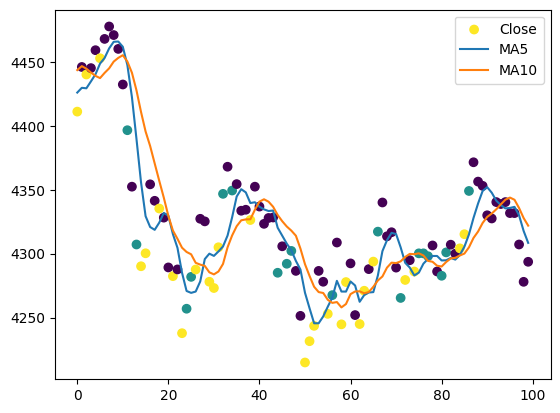

In [50]:
plt.scatter(range(100), handler.data['Close'][0:100], c=handler.data['Label'][0:100], label="Close")
plt.plot(range(100), handler.data[f'MA{ma1}'][0:100], label=f"MA{ma1}")
plt.plot(range(100), handler.data[f'MA{ma2}'][0:100], label=f"MA{ma2}")
plt.legend()
plt.show()

In [51]:
predict_data

,Unix,RSI Var,MACD Var,MACD_H Var,ADX14 Var,-DM Var,+DM Var,OBV Var,NTrades Var,RSI_30-,RSI_BTW,RSI_70+,LOG_RET,Target,Kendall_5,Kendall_10,MA5 Var,MA10 Var,Close_MA5_PERC_DIFF,Close_MA10_PERC_DIFF,MA5 UP,MA10 UP,Crossover_Lag_1__-1,Crossover_Lag_1__0,Crossover_Lag_1__1
0,1502973900000,-0.071956,-0.114149,0.259602,-0.062045,-0.058502,-0.058620,-1.762928,-0.062500,0,1,0,-0.004553,1.0,-0.4,-0.333333,-0.002656,-0.000652,0.003374,0.007358,0,1,0,1,0
1,1502974800000,0.105905,-0.028740,-0.118619,-0.042160,-0.098601,0.042958,-2.507813,-0.333333,0,1,0,0.007876,-1.0,0.0,-0.466667,0.000840,0.000695,-0.003662,0.000149,0,1,0,1,0
2,1502975700000,-0.021039,-0.049092,-0.046814,-0.039545,-0.066181,-0.066181,-2.912572,0.400000,0,1,0,-0.001323,1.0,0.4,-0.422222,-0.000084,-0.000450,-0.002427,0.001023,0,1,0,1,0
3,1502976600000,0.014177,-0.038866,-0.079011,-0.030784,-0.057126,-0.006814,-4.181738,1.928571,0,1,0,0.001125,-1.0,0.4,-0.200000,0.001214,-0.000670,-0.002339,-0.000773,0,1,0,1,0
4,1502977500000,0.039125,-0.005272,-0.182874,-0.011499,-0.094063,0.044319,1.368353,0.292683,0,1,0,0.003145,-1.0,0.6,0.155556,0.001257,-0.000594,-0.004222,-0.004503,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193353,1677534300000,0.001017,-0.213901,0.149378,-0.038023,-0.025595,-0.025595,-0.354712,-0.165560,0,1,0,0.000024,1.0,1.0,0.644444,0.001166,0.000273,-0.001162,-0.003202,1,0,0,1,0
193354,1677535200000,0.014889,-0.247293,0.076254,-0.058809,-0.059674,0.137429,0.660667,0.279743,0,1,0,0.000332,1.0,1.0,0.822222,0.000580,0.000430,-0.000914,-0.003104,1,0,0,1,0
193355,1677536100000,-0.021328,-0.231473,-0.019154,-0.057936,-0.047305,-0.047950,-1.694105,-0.244106,0,1,0,-0.000411,1.0,0.4,0.822222,0.000365,0.000443,-0.000138,-0.002253,1,0,0,1,0
193356,1677537000000,0.037652,-0.337270,0.006464,-0.057106,-0.033850,-0.033850,-1.726043,-0.105301,0,1,0,0.000760,1.0,0.4,0.822222,0.000399,0.000737,-0.000499,-0.002276,1,0,0,1,0


In [52]:
dataset = TSDataset(predict_data, seq_length)

In [53]:
train_indices = range(0, round(0.7 * len(dataset)), idx_skip)
val_indices = range(round(0.7 * len(dataset)), round(0.9 * len(dataset)), idx_skip)
test_indices = range(round(0.9 * len(dataset)), len(dataset) - seq_length)

train_set = torch.utils.data.Subset(dataset, train_indices)
val_set = torch.utils.data.Subset(dataset, val_indices) # Validation set will be training set for Meta Labelling
test_set = torch.utils.data.Subset(dataset, test_indices)

In [54]:
label_distribution = (predict_data.loc[train_set.indices, 'Target'].value_counts() / predict_data.loc[train_set.indices, 'Target'].shape[0]).sort_index().to_list()
display(predict_data.loc[train_set.indices, 'Target'].value_counts())
label_distribution

Target
-1.0    3070
 1.0    3065
 0.0    2888
Name: count, dtype: int64

[0.3402416047877646, 0.32007092984594926, 0.33968746536628613]

In [55]:
class_weights = [1 / p for p in label_distribution]
print(class_weights)
# class_weights = [4, 1, 4]
weights = [class_weights[torch.argmax(label)] for _, label in train_set]
train_sampler = WeightedRandomSampler(weights=weights, num_samples=len(train_set), replacement=True)
# train_sampler = None

[2.939087947882736, 3.1243074792243766, 2.9438825448613377]


In [56]:
input_size = dataset.size
hidden_size = 500
batch_size = 32
num_layers = 1
output_size = predict_data['Target'].unique().size
lstm_model = LSTMModel(input_size, hidden_size,
                       num_layers, output_size).to(device)

In [57]:
weights = torch.Tensor(label_distribution).to(device)
train_lstm(lstm_model, train_set, val_set, 30, 0.00001,
           batch_size, num_layers, hidden_size, device, train_sampler, class_weights=None, model_name=f'agent_{seq_length}_to_{agent_horizon}', save=True)

Epoch: 1/30 -- [8742/9023 (100.0%)]	Loss: 1.098709340213884	Accuracy: 0.336	Time taken: 15.265625	Validation Loss: 1.1026362180709839 || Validation Accuracy: 0.240
Epoch: 2/30 -- [8742/9023 (100.0%)]	Loss: 1.0987293267926426	Accuracy: 0.337	Time taken: 15.03125	Validation Loss: 1.102416753768921 || Validation Accuracy: 0.240
Epoch: 3/30 -- [8742/9023 (100.0%)]	Loss: 1.0984633974995173	Accuracy: 0.339	Time taken: 14.65625	Validation Loss: 1.1023699045181274 || Validation Accuracy: 0.240
Epoch: 4/30 -- [8742/9023 (100.0%)]	Loss: 1.098356472262254	Accuracy: 0.344	Time taken: 15.21875	Validation Loss: 1.1025358438491821 || Validation Accuracy: 0.240
Epoch: 5/30 -- [8742/9023 (100.0%)]	Loss: 1.0984379463161982	Accuracy: 0.332	Time taken: 14.5	Validation Loss: 1.1021015644073486 || Validation Accuracy: 0.239
Epoch: 6/30 -- [8742/9023 (100.0%)]	Loss: 1.098682665233071	Accuracy: 0.329	Time taken: 15.140625	Validation Loss: 1.1012476682662964 || Validation Accuracy: 0.242
Epoch: 7/30 -- [8742/9

([1.098709340213884,
  1.0987293267926426,
  1.0984633974995173,
  1.098356472262254,
  1.0984379463161982,
  1.098682665233071,
  1.098176196957311,
  1.0982657015746367,
  1.0981398398149098,
  1.097905343728708,
  1.0979332873161802,
  1.0974015851392813,
  1.0973540443055174,
  1.097044472576033,
  1.0971863367033343,
  1.0960018398068476,
  1.096158798704756,
  1.0947067120396499,
  1.0940967726369275,
  1.0941338868851358,
  1.0927405137542292,
  1.0934697144420435,
  1.0925370340651654,
  1.0911866815377635,
  1.09169546805375,
  1.08940397382628,
  1.0898237270666353,
  1.090842827837518,
  1.0920890675368884,
  1.089045060019121],
 [0.3359193173002327,
  0.33713842402748534,
  0.33902249806051205,
  0.34389892496952235,
  0.33204034134988364,
  0.3294913000110828,
  0.3327053086556578,
  0.348997007647124,
  0.35154604898592484,
  0.35464922974620416,
  0.3556466807048653,
  0.36174221434112824,
  0.3608555912667627,
  0.365732018175773,
  0.3533192951346559,
  0.3724925191178

In [58]:
eval_lstm(lstm_model, test_set, 64, num_layers, hidden_size, device)

Accuracy : 0.36451162068430043 || Loss : 1.1020801067352295
Confusion matrix : 
[[1873. 1406. 1365.]
 [4136. 3886. 2129.]
 [2040. 1201. 1283.]]


(tensor([[0.5510, 0.0999, 0.3491],
         [0.5469, 0.0871, 0.3659],
         [0.5253, 0.0864, 0.3883],
         ...,
         [0.2523, 0.3947, 0.3531],
         [0.2473, 0.3963, 0.3564],
         [0.2535, 0.3802, 0.3664]], device='cuda:0', grad_fn=<CatBackward0>),
 tensor([[1., 0., 0.],
         [1., 0., 0.],
         [0., 0., 1.],
         ...,
         [0., 0., 1.],
         [0., 1., 0.],
         [1., 0., 0.]], device='cuda:0'))